# Feature Exploration and Selection

We have 89 features and only 40-ish data points per player. Clearly we are going to need to reduce our feature space. In this notebook, we'll take a stab at doing this manually by building correlation plots between our taget and each feature. We'll also look at a correlation matrix of all features to see where there might be some overlap.

In the two notebooks after this one, we'll build an XGBoost model and look at feature importance. Finally, we'll perform PCA before building the neural network.

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from numpy.polynomial.polynomial import polyfit
from scipy.stats import pearsonr, zscore
import seaborn as sns

plt.style.use('ggplot')

In [2]:
# Read in features
features = {}
path = '../data/data_final/final/features_raw'
for filename in os.listdir(path):
    if '.csv' in filename:
        features[filename.split('.')[0]] = pd.read_csv(os.path.join(path,filename))

In [3]:
# Define function to create and save correlation plots
def plot_correlations(feature_df, foldername):
    target = feature_df['target']
    for col in feature_df.columns:
        if col != 'target':
            x_var = feature_df[col].copy()
            x_var.fillna(value=x_var.median(), inplace=True) # Naive Bayes to fill NAs for regression line
            x_var.loc[zscore(x_var) > 3] = x_var.median() # Replace outliers with median
            b, m = polyfit(x_var, target, 1)
            fig, ax = plt.subplots()
            plt.scatter(feature_df[col], target, alpha=0.7)
            plt.plot(x_var, b + m * x_var, '-', color='black')
            anchored_text = AnchoredText('R = {:.2%}'.format(pearsonr(x_var, target)[0]) , 2)
            ax.add_artist(anchored_text)
            plt.title('{} vs fantasy points'.format(col))
            plt.xlabel('{}'.format(col))
            plt.ylabel('fantasy points scored')
            plt.savefig('../plots/correlation_plots/{}/{}_corr.png'.format(foldername, col))
            plt.close()

In [93]:
%%time
for key, value in features.items():
    plot_correlations(value, key)

CPU times: user 41.9 s, sys: 5.22 s, total: 47.2 s
Wall time: 16.3 s


Correlation plots now exist in the `plots/correlation_plots` folder. There are too many to print here.

The high-level takeaway is that the defensive features (pass + rush yards allowed), betting features (spread), and weather features (temperature) look to be the strongest. However, some of the twitter features, such as pct_neutral, have decent signal. 

The correlations are also quite different for each player. For example, the 'sacks' features are pretty strong for Brady (a QB), but not so strong for McCoy (an RB). 

On the whole, it would be a bit of a fool's errand to perform manual feature selection because there is so much going on.

Now let's look at the overall correlation matrix.

In [4]:
# https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
plt.rcParams['figure.figsize'] = [25, 25]

def heatmap(x, y, size, corrval):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
    color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
        ind = int(val_position * (n_colors - 1)) # target index in the color palette
        return palette[ind]
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        c=corrval.apply(value_to_color), # Vector of square color values, mapped to color palette
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=90, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])

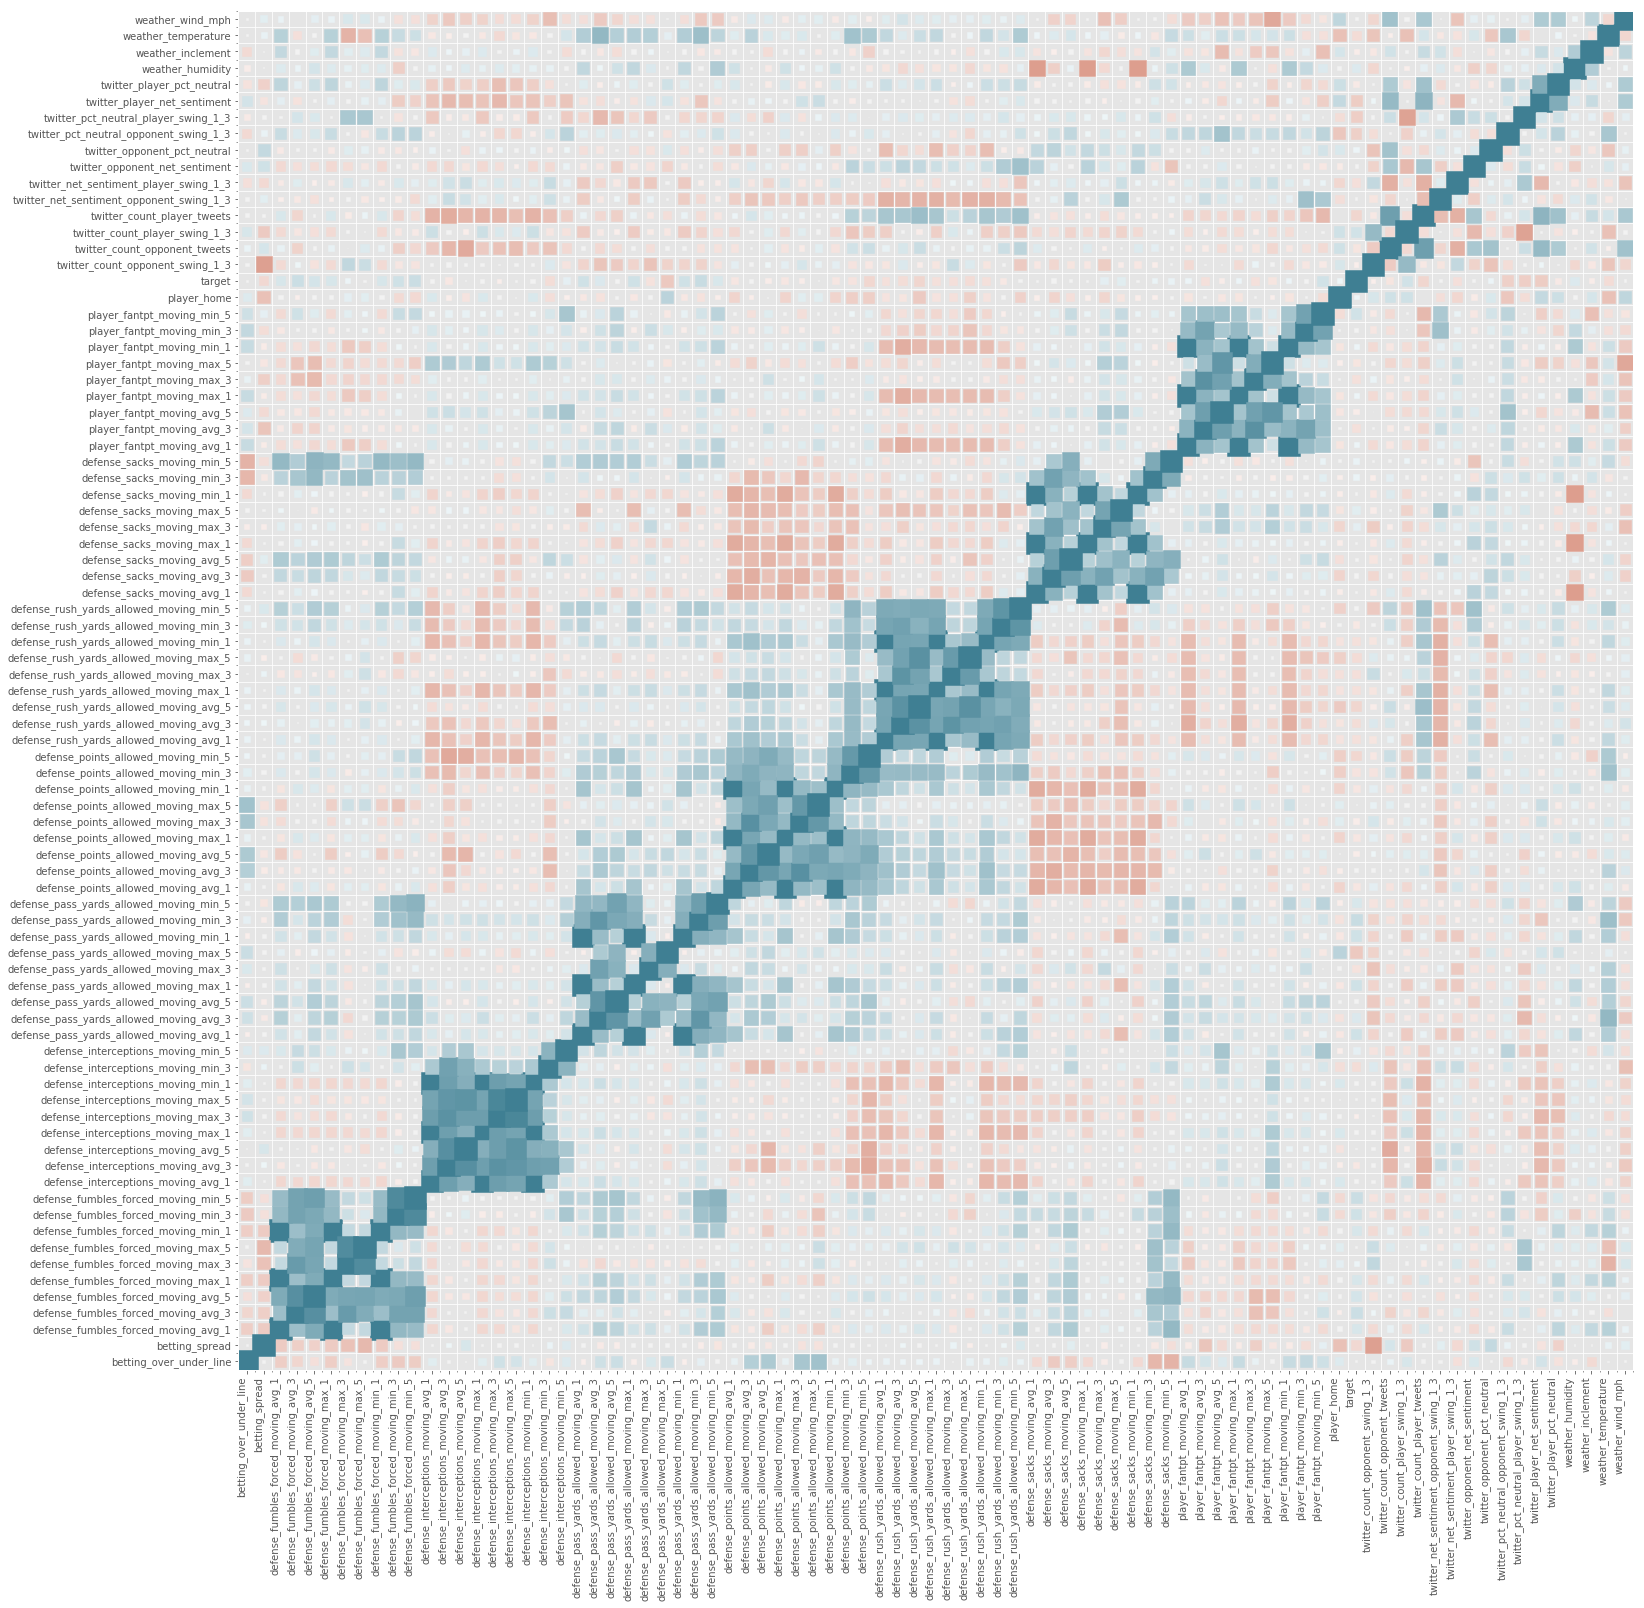

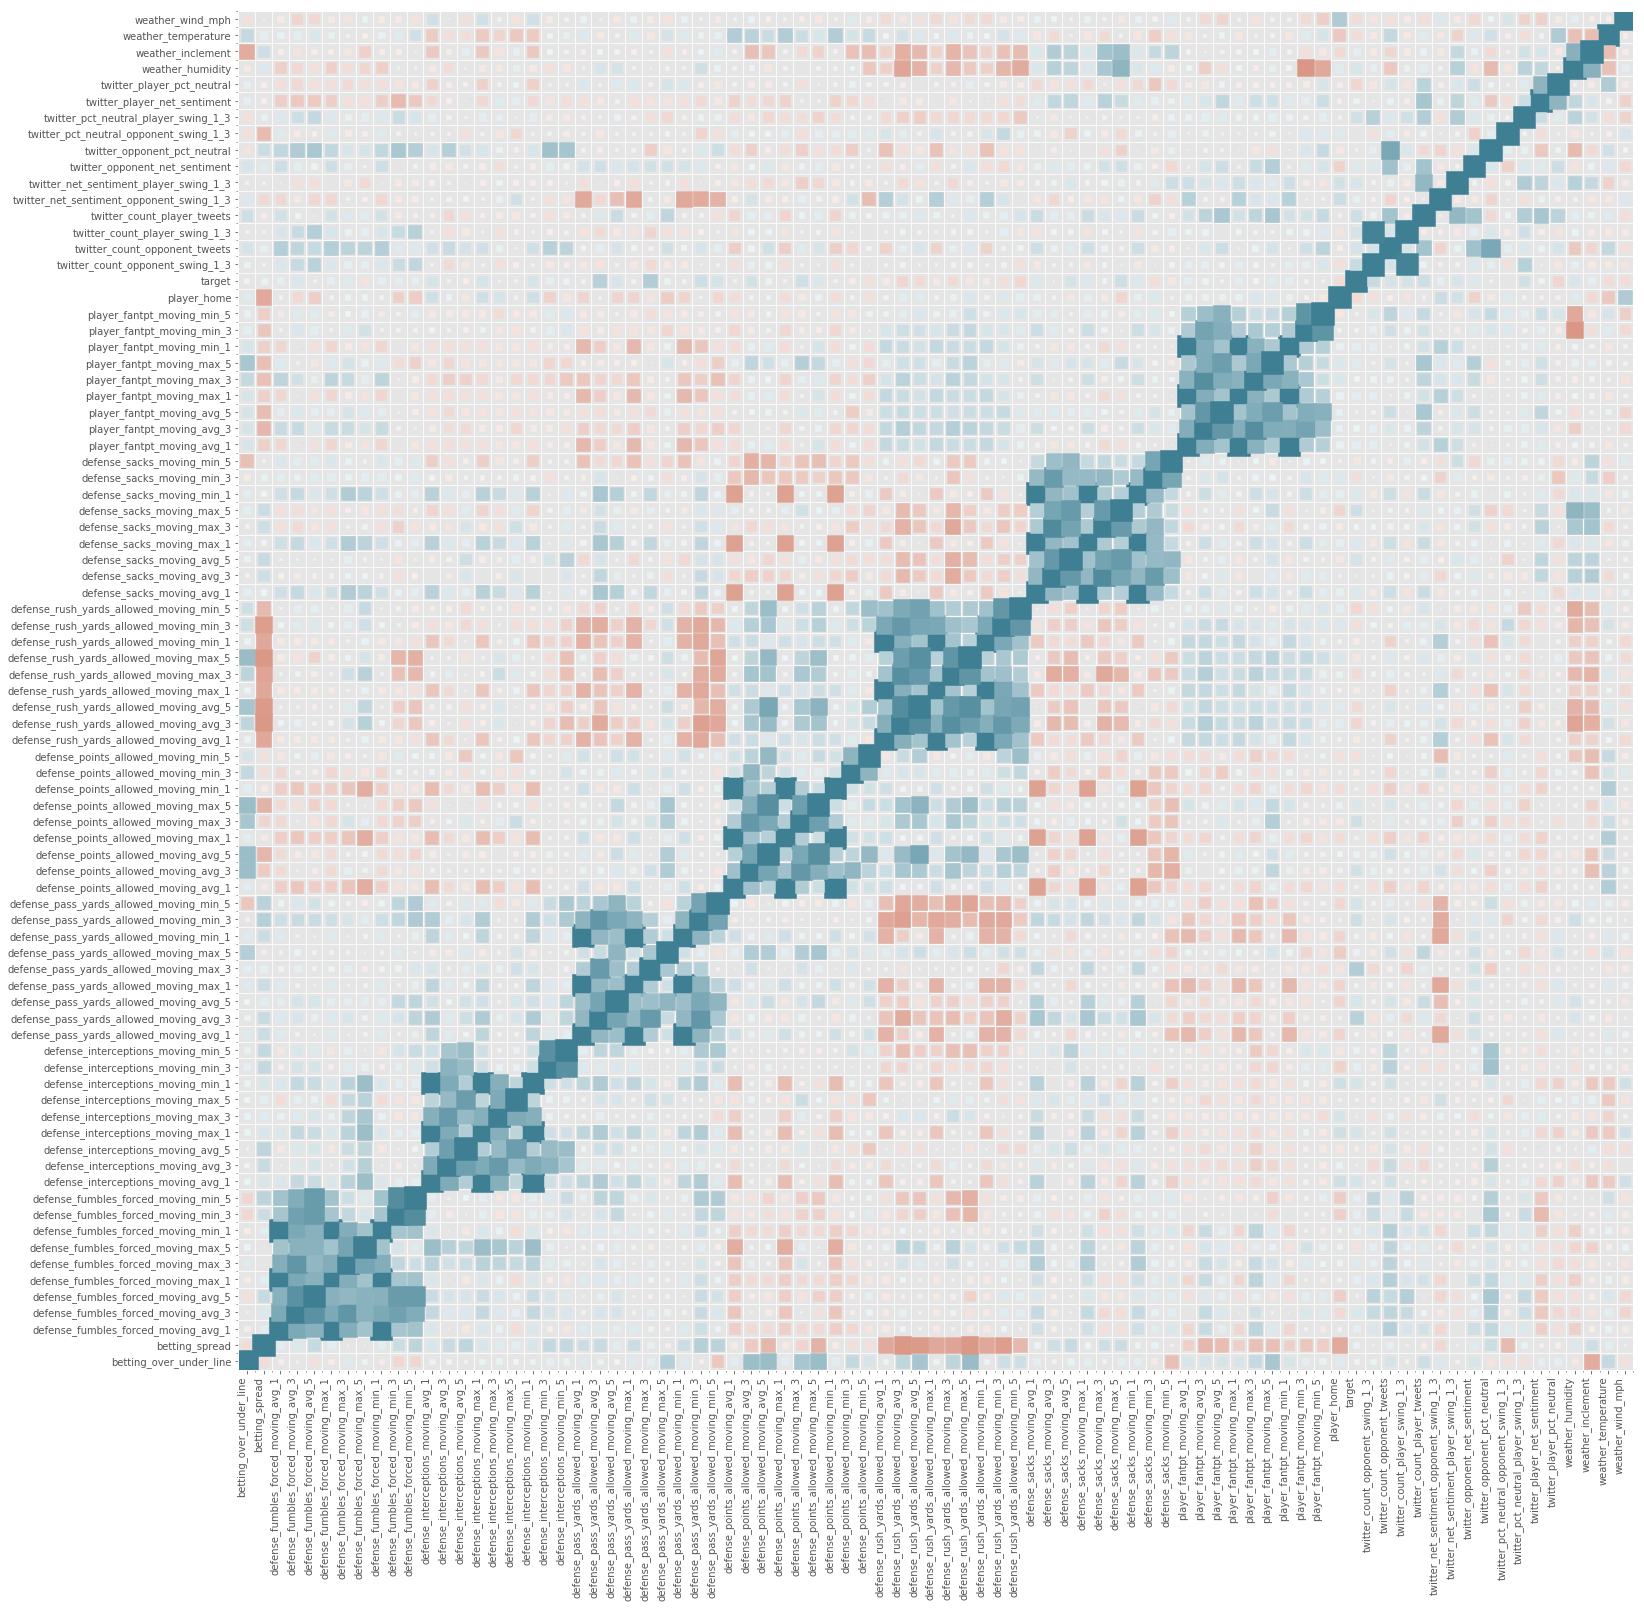

In [6]:
for key, value in features.items():
    corr = value.corr()
    corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
    corr.columns = ['x', 'y', 'value']
    heatmap(
        x=corr['x'],
        y=corr['y'],
        size=corr['value'].abs(),
        corrval=corr['value']
    )
    plt.savefig('../plots/correlation_plots/heatmaps/{}_corr.png'.format(key))

These plots are huge and a little intimidating. But, if we take time to scrutinize them, we can pick up on some really interesting insights.

As a few examples, the big squares/triangles in the middle show us that a lot of our different-windowed moving averages on the same metrics are highly correlated, as we would expect. We can also see that the betting spread is highly correlated with the defensive yards allowed moving averages. Finally, some of the Twitter features are correlated with big defensive events, like fumbles and interceptions.

There's a lot more interesting information here, and in the future it would be nice to revisit this plot and further hone feature selection manually.